#### This test notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [ ]:
# Testing if integration works

In [113]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import torch

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [114]:

sample_file_name = 'sample_data/sample_output'
sample_item = torch.load(sample_file_name)
sample_item = sample_item[0] + 1j * sample_item[1]

file_name = 'data/dev_data/singlecoil_train/file1000400.h5'
# file_name = 'fastmri_examples/unet/unet/unet_demo/reconstructions/file1000702.h5'
# file_name = '../data/singlecoil_test/file1000702.h5'
# file_name = 'fastmri_examples/unet/unet_pretrained_results/reconstructions/file1000702.h5'
hf = h5py.File(file_name)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/dev_data/singlecoil_train/file1000400.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [115]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0006488847639158681, 'norm': 0.27459500616644683, 'patient_id': '3347399c8d6f61e725dc0ff50b105fb0cf47b6553ad38e8fa70425c1a754914d'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [116]:
volume_kspace = hf['kspace'][()]
# volume_kspace = hf['reconstruction'][()]
# volume_kspace = hf['reconstruction_esc'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(42, 640, 368)


In [117]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [118]:
def show_coils(data, cmap=None):
    fig = plt.figure()
    plt.subplot(1, 1, 1)
#         plt.imshow(data[num], cmap=cmap)
    plt.imshow(data, cmap=cmap)

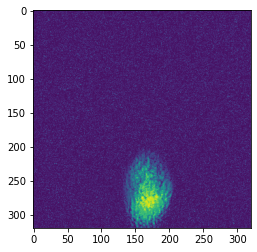

In [121]:
with torch.no_grad():
    # show_coils(np.log(np.abs(torch.Tensor.cpu(sample_item).numpy()) + 1e-9))
    show_coils(np.abs(torch.Tensor.cpu(sample_item).numpy()))
# show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
# show_coils(np.log(np.abs(slice_kspace) + 1e-9))

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [78]:
import fastmri
from fastmri.data import transforms as T

In [101]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

KeyboardInterrupt: 

In [77]:
# show_coils(slice_image_abs, [0, 5, 10], cmap='gray')
show_coils(slice_image_abs, cmap='gray')

KeyboardInterrupt: 

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [40]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

NameError: name 'slice_image_abs' is not defined

TypeError: Invalid shape (368,) for image data

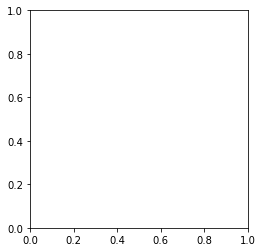

In [53]:
# plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [34]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [35]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

NameError: name 'T' is not defined

Let's see what the subsampled image looks like:

In [36]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

NameError: name 'fastmri' is not defined

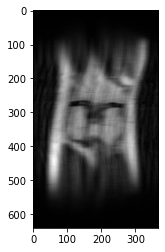

In [56]:
# plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')
plt.imshow(np.abs(sampled_image_abs.numpy()), cmap='gray')